In [3]:
from O.MM.sc_system import *

an automatic method (get_index_average_box_automatic_) was added, and being tested, to replace the supervised method dicussed here.
this notebook is still shown because get_index_average_box_automatic_ was not yet used in the paper

# minimal example equilibrating one supercell at finite pressure

In [ ]:
# extracting an equilibrated supercell in each system was largely done by hand so far, and not yet automated

''' note for the end of the notebook:
in some cases a box vector component randomly changes sign, making one of the 3 box angles oscillate between two positions
this looks like a histogram with two diconnected peaks for this angle (e.g., veliparib Form II; seen later in this notebook)
this is just an artifact of the wrapping, however still need to get a physical average from such histogram
to find average_box that visually matches the most probable values (including the 'oscillating' angle),
the following steps were used: these are shown at the end of the notebook in 'veliparib_dataset_II_NPT_cell_131' as example.
'''

In [65]:
def plot_box_lengths_angles_histograms_(boxes, b0 = None, b1=None):
    cell_NPT = cell_lengths_and_angles_(boxes)
    if b0 is None: b0 = np.array(boxes[0])
    else: b0 = np.array(b0).reshape([3,3])
    if b1 is None: b1 = np.array(b0)
    else: b1 = np.array(b1).reshape([3,3])

    cell_in = cell_lengths_and_angles_(b0)
    cell_out = cell_lengths_and_angles_(b1)
    
    #fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
    Max0 = max([
        plot_1D_histogram_(cell_NPT[:,0], bins=30, ax=ax[0], return_max_y=True, color='C0'),
        plot_1D_histogram_(cell_NPT[:,1], bins=30, ax=ax[0], return_max_y=True, color='C1'),
        plot_1D_histogram_(cell_NPT[:,2], bins=30, ax=ax[0], return_max_y=True, color='C2'),
        ])
    for i in range(0,3):
        ax[0].plot([cell_in[i]]*2, [0,Max0], color='C'+str(i), linestyle='dotted', linewidth=1.5)
        ax[0].plot([cell_out[i]]*2, [0, Max0], color='C'+str(i), linewidth=1.5)
    Max1 = max([
        plot_1D_histogram_(cell_NPT[:,3], bins=30, ax=ax[1], return_max_y=True, color='C0'),
        plot_1D_histogram_(cell_NPT[:,4], bins=30, ax=ax[1], return_max_y=True, color='C1'),
        plot_1D_histogram_(cell_NPT[:,5], bins=30, ax=ax[1], return_max_y=True, color='C2'),
        ])
    for i in range(3,6):
        ax[1].plot([cell_in[i]]*2, [0,Max1], color='C'+str(i-3), linestyle='dotted', linewidth=1.5)
        ax[1].plot([cell_out[i]]*2, [0,Max1], color='C'+str(i-3), linewidth=1.5)

    ax[0].set_xlabel('box vector lengths / nm')
    ax[1].set_xlabel('box vector angles / degrees')
    
    plt.tight_layout()
    #plt.show()

In [5]:
# initial (ideal) supercell
PDB_supercell = './O/MM/GAFF_sc_rerun/succinic_acid/succinic_acid_Ae_unitcell_cell223.pdb'

In [6]:
# FF
sc = SingleComponent(PDB = str(PDB_supercell), n_atoms_mol=14, name='succinic_acid', FF_name='GAFF')
sc.initialise_system_(PME_cutoff=0.36, nonbondedMethod=app.PME)
# MD at P=1atm, T=300K
sc.initialise_simulation_( timestep_ps = 0.002,  # ps
                            P = 1,               # atm
                            T = 300,             # K
                            barostat_type = 2,   # fully felxible
                            minimise = True,
                            )

# initialise_object (SingleComponent) with GAFF FF, from the input file (PDB):
n_molecules: 24

# initialise_system:
set PME cutoff to: 0.36 nm
removeCMMotion active: True

__ changing n_mol in top: ________________________________
in the /mnt/c/Users/User/Desktop/FEcrys/O/MM/GAFF_sc_rerun/succinic_acid/misc/x_succinic_acid_gmx.top
replaced 1 line ( 165 ) 
 from: 
     UNK                  1
 to 
     UNK                  24
these changes were written into file: /mnt/c/Users/User/Desktop/FEcrys/O/MM/GAFF_sc_rerun/succinic_acid/misc/x_x_succinic_acid_gmx.top
__________________________________________________________

set SwitchingFunction to 0.95 * PME_cutoff = 0.34199999999999997 nm
adjusted EwaldErrorTolerance from 0.0005 to 0.0001
n_mol =  24, n_atoms_mol = 14, N = 336, n_DOF = 1005 (n_constraints = 3) 

# initialise_simulation:
set temperature: 300 Kelvin
set integration timestep: 0.002 ps
set collision rate (friction ceofficent): 1 /ps
setting barostat ( MonteCarloFlexibleBarostat 

In [15]:
# running for 5ns
sc.run_simulation_(50000,50)

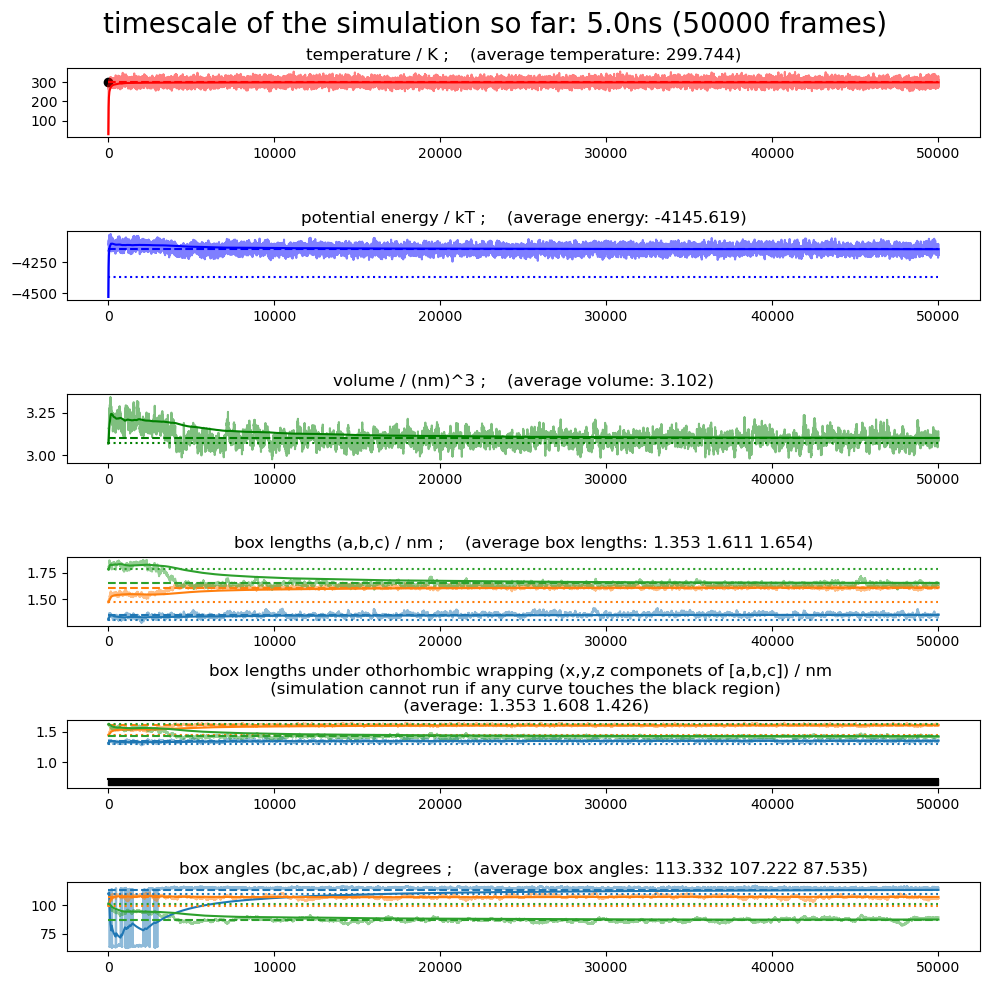

In [19]:
# check if things look converged; Looking to see the smooth curves (cumulative averages) flatten out
sc.plot_simulation_info_()

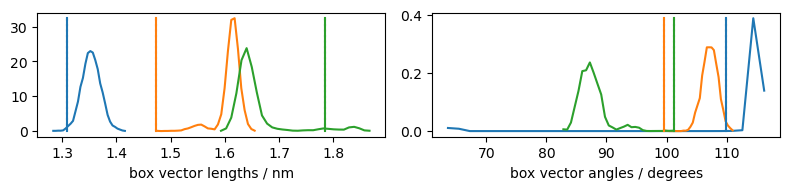

In [61]:
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)

# plotting histograms of box shape during the simulation
plot_box_lengths_angles_histograms_(sc.boxes, b0=sc.b0, b1=sc.b0)

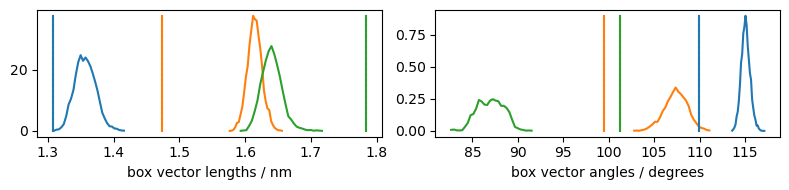

In [62]:
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)

# plotting histograms of box shape when the simulation seems converged
plot_box_lengths_angles_histograms_(sc.boxes[20000:], b0=sc.b0, b1=sc.b0)

In [191]:
# in the converged part of simulation find index of supercell with box that is most similar to the average box shape

# last axis (6 DOFs of the box) : [length_a, length_b, length_c, length_bc, length_ac, length_ab]
lengths_angles = cell_lengths_and_angles_(sc.boxes) # (m,6)

# converged region looks like approximately after 20,000 frames (after ~ this point all the averaged curves look flat):
average_box = lengths_angles[20000:].mean(0,keepdims=True)

err = np.abs(average_box - lengths_angles) # err but not standardised
err /= err.max(0, keepdims=True) # error standardised to give the same 'weight' for each of the 6 DOFs
err = err.sum(-1)                # (m,)
index = np.argmin(err)
print('frame with index',index,'is closest to average in terms of box shape')

# index out the box that is closes to the average box
b1 = np.array(sc.boxes[index]) # (3,3)

frame with index 39701 is closest to average in terms of box shape


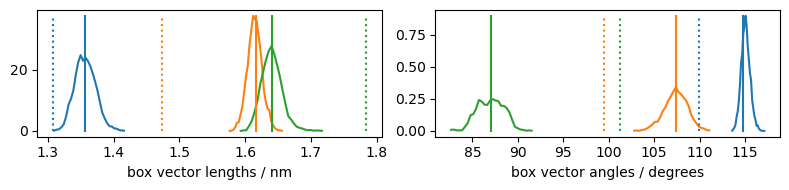

In [192]:
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)

# checking that the box of the indexed structure is close to average
# solid lines are for b1 (indexed box), and dotted lines for b0 (initial box)
plot_box_lengths_angles_histograms_(sc.boxes[20000:], b0=sc.b0, b1=b1)

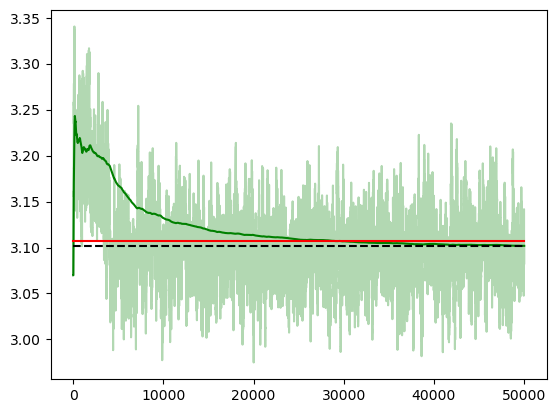

In [193]:
# checking that the volume of the indexed supercell also matches the converged average volume (black dotted line)
sc.plot_volume_()
plt.plot([0,50000],[np.linalg.det(b1)]*2, color='red')

In [194]:
# minimising the supercell (optional, because at start of each later NVT simulation minimised anyway)
r1 = np.array(sc.xyz[index])
r1_min = sc.minimise_xyz_(r1[np.newaxis,...], b1[np.newaxis,...], verbose=True)

u before minimisation: -4159.632741360438 kT
u after  minimisation: -4653.644392490132 kT


In [195]:
# saving the 'eqm cell' (equilibrated supercell)
sc.save_pdb_(r1, b=b1, name='./O/MM/GAFF_sc/succinic_acid/succinic_acid_Ae_equilibrated_cell_223_repeat.pdb')

saved: ./O/MM/GAFF_sc/succinic_acid/succinic_acid_Ae_equilibrated_cell_223_repeat.pdb


In [196]:
# checking if the equilibrated supercell box looks similar to the previous simulation

[PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_Ae_equilibrated_cell_223.pdb'),
PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_Ae_equilibrated_cell_223_repeat.pdb')]

[array([[ 1.3567    ,  0.        ,  0.        ],
        [ 0.0895333 ,  1.6115147 ,  0.        ],
        [-0.49198997, -0.6708571 ,  1.423646  ]], dtype=float32),
 array([[ 1.3566    ,  0.        ,  0.        ],
        [ 0.08352045,  1.6152421 ,  0.        ],
        [-0.49200216, -0.6626329 ,  1.4180084 ]], dtype=float32)]

In [197]:
# checking if the equilibrated supercell box looks similar to the previous simulation

boxes_old = load_pickle_('./O/MM/GAFF_sc/succinic_acid/data/succinic_acid_dataset_Ae_NPT_cell_223')['MD dataset']['b']
b1_old = PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_Ae_equilibrated_cell_223.pdb')

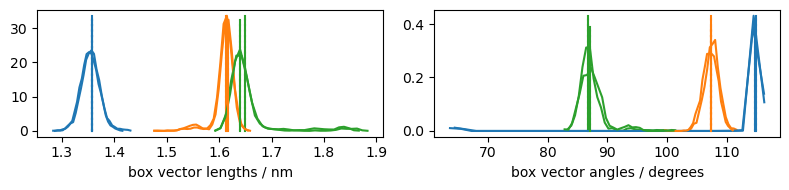

In [198]:
# checking if the equilibrated supercell box looks similar to the previous simulation
# also, are the two simulations similar

fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)

plot_box_lengths_angles_histograms_(boxes_old, b0=b1_old, b1=b1_old)
plot_box_lengths_angles_histograms_(sc.boxes, b0=b1, b1=b1)

In [ ]:
## ## ## ##

# showing that extacted eqm cell from each NPT simulation was close to average box shape

In [ ]:
# alpha succinic acid

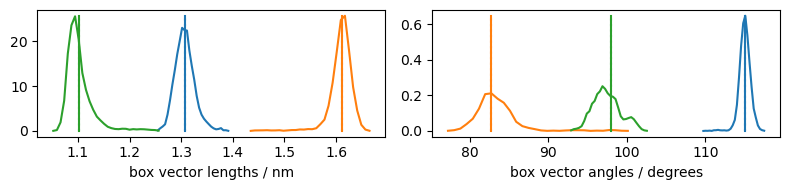

In [100]:
_boxes = load_pickle_('./O/MM/GAFF_sc/succinic_acid/data/succinic_acid_dataset_Ae_NPT_cell_222')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_Ae_equilibrated_v2_cell_222.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

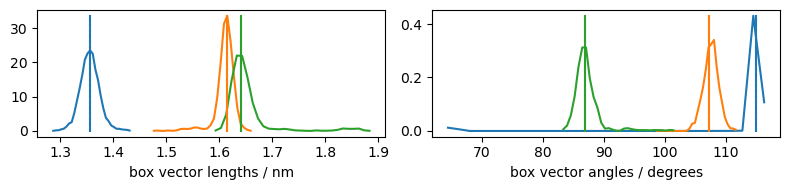

In [101]:
_boxes = load_pickle_('./O/MM/GAFF_sc/succinic_acid/data/succinic_acid_dataset_Ae_NPT_cell_223')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_Ae_equilibrated_v2_cell_223.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

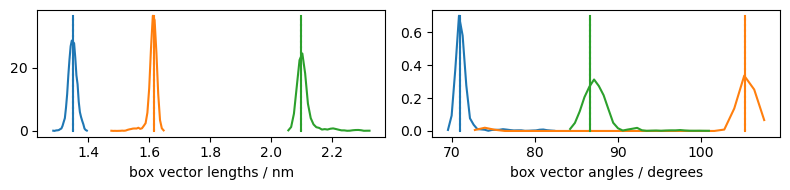

In [102]:
_boxes = load_pickle_('./O/MM/GAFF_sc/succinic_acid/data/succinic_acid_dataset_Ae_NPT_cell_224')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_Ae_equilibrated_v2_cell_224.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

In [ ]:
# beta succinic acid

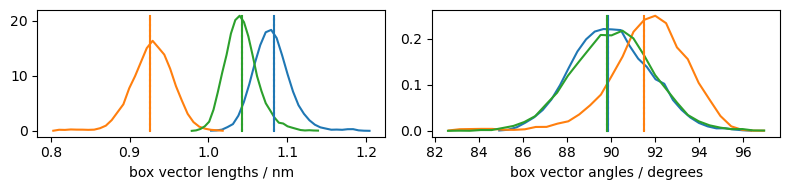

In [104]:
_boxes = load_pickle_('./O/MM/GAFF_sc/succinic_acid/data/succinic_acid_dataset_Be_NPT_cell_212')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_Be_equilibrated_v2_cell_212.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

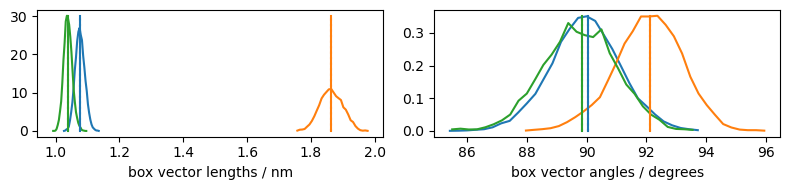

In [105]:
_boxes = load_pickle_('./O/MM/GAFF_sc/succinic_acid/data/succinic_acid_dataset_Be_NPT_cell_222')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_Be_equilibrated_v2_cell_222.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

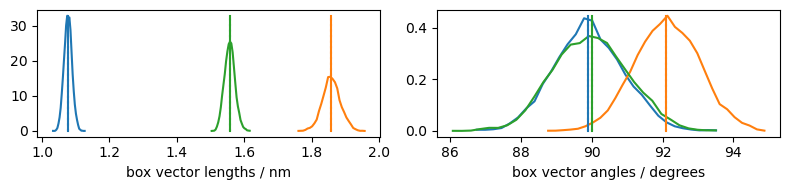

In [106]:
_boxes = load_pickle_('./O/MM/GAFF_sc/succinic_acid/data/succinic_acid_dataset_Be_NPT_cell_223')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_Be_equilibrated_v2_cell_223.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

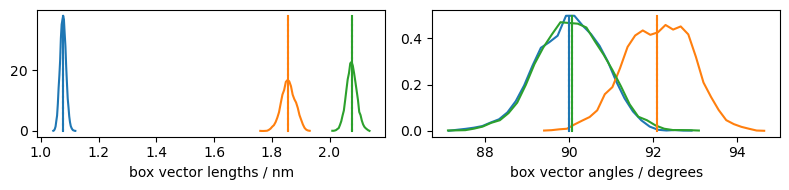

In [107]:
_boxes = load_pickle_('./O/MM/GAFF_sc/succinic_acid/data/succinic_acid_dataset_Be_NPT_cell_224')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_Be_equilibrated_v2_cell_224.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

In [ ]:
# gamma succinic acid

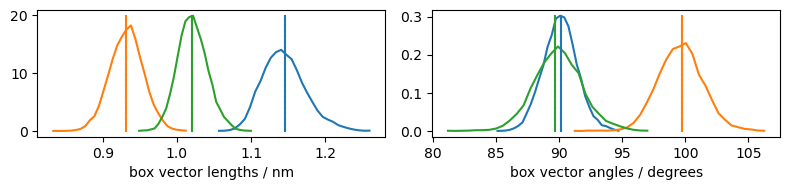

In [108]:
_boxes = load_pickle_('./O/MM/GAFF_sc/succinic_acid/data/succinic_acid_dataset_G_NPT_cell_211')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_G_equilibrated_v2_cell_211.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

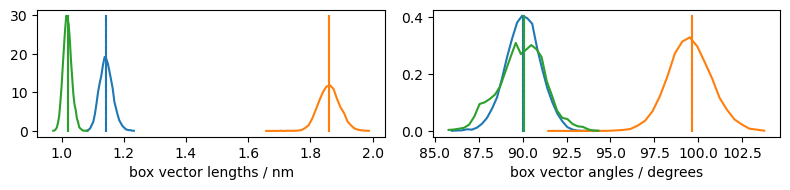

In [109]:
_boxes = load_pickle_('./O/MM/GAFF_sc/succinic_acid/data/succinic_acid_dataset_G_NPT_cell_221')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_G_equilibrated_v2_cell_221.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

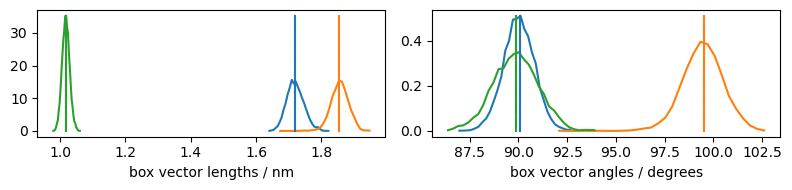

In [110]:
_boxes = load_pickle_('./O/MM/GAFF_sc/succinic_acid/data/succinic_acid_dataset_G_NPT_cell_321')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_G_equilibrated_v2_cell_321.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

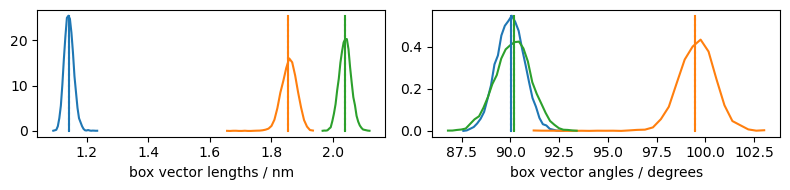

In [111]:
_boxes = load_pickle_('./O/MM/GAFF_sc/succinic_acid/data/succinic_acid_dataset_G_NPT_cell_222')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/succinic_acid/succinic_acid_G_equilibrated_v2_cell_222.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

In [ ]:
# Veliparib Form I

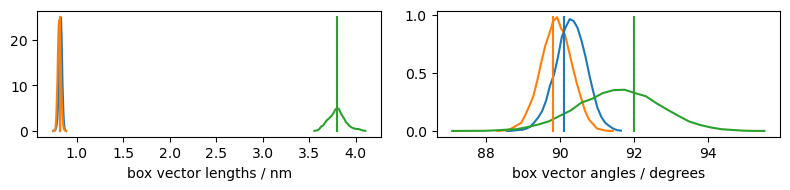

In [112]:
_boxes = load_pickle_('./O/MM/GAFF_sc/veliparib/data/veliparib_dataset_I_NPT_cell_111')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/veliparib/veliparib_I_equilibrated_cell_111.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

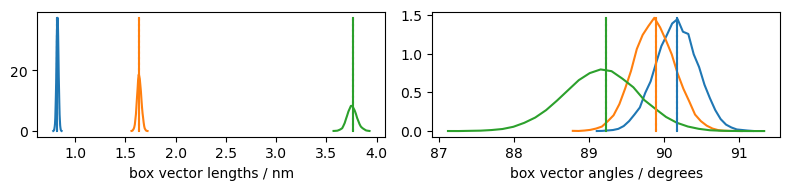

In [113]:
_boxes = load_pickle_('./O/MM/GAFF_sc/veliparib/data/veliparib_dataset_I_NPT_cell_121')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/veliparib/veliparib_I_equilibrated_cell_121.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

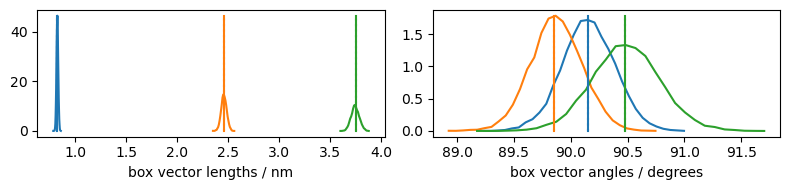

In [114]:
_boxes = load_pickle_('./O/MM/GAFF_sc/veliparib/data/veliparib_dataset_I_NPT_cell_131')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/veliparib/veliparib_I_equilibrated_cell_131.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

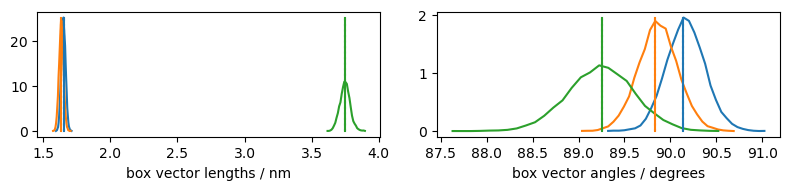

In [115]:
_boxes = load_pickle_('./O/MM/GAFF_sc/veliparib/data/veliparib_dataset_I_NPT_cell_221')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/veliparib/veliparib_I_equilibrated_cell_221.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

In [ ]:
# Veliparib Form II

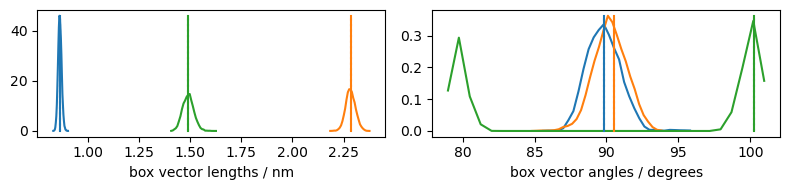

In [116]:
_boxes = load_pickle_('./O/MM/GAFF_sc/veliparib/data/veliparib_dataset_II_NPT_cell_131')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/veliparib/veliparib_II_equilibrated_cell_131.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

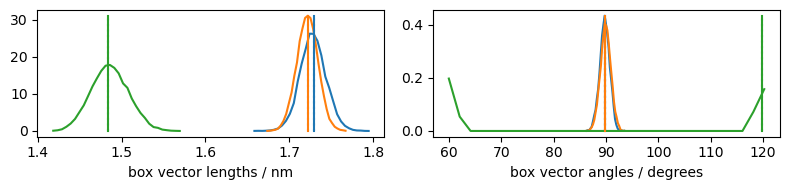

In [117]:
_boxes = load_pickle_('./O/MM/GAFF_sc/veliparib/data/veliparib_dataset_II_NPT_cell_221')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/veliparib/veliparib_II_equilibrated_cell_221.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

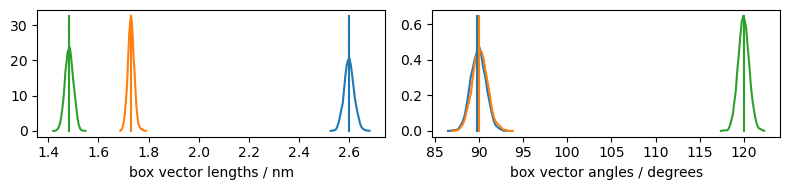

In [118]:
_boxes = load_pickle_('./O/MM/GAFF_sc/veliparib/data/veliparib_dataset_II_NPT_cell_321')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/veliparib/veliparib_II_equilibrated_cell_321.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

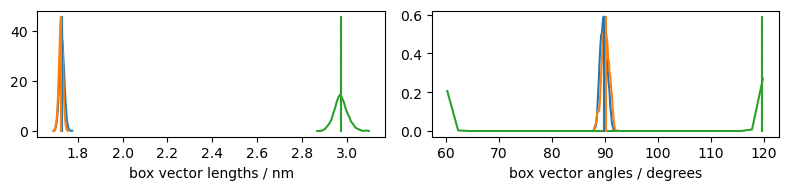

In [119]:
_boxes = load_pickle_('./O/MM/GAFF_sc/veliparib/data/veliparib_dataset_II_NPT_cell_222')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/veliparib/veliparib_II_equilibrated_cell_222.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

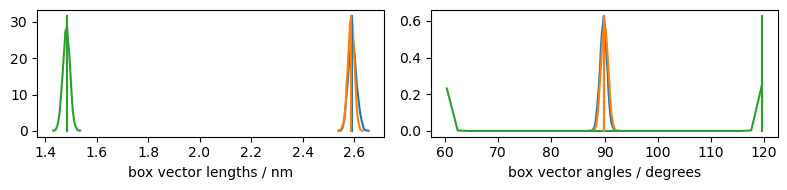

In [120]:
_boxes = load_pickle_('./O/MM/GAFF_sc/veliparib/data/veliparib_dataset_II_NPT_cell_331')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/veliparib/veliparib_II_equilibrated_cell_331.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

In [ ]:
# Mivebresib Form I

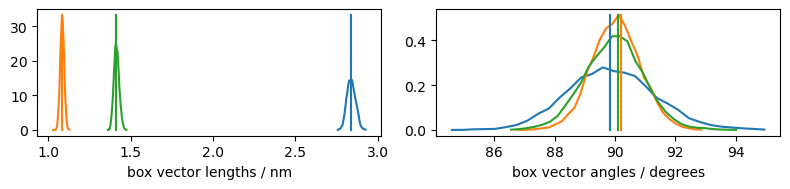

In [121]:
_boxes = load_pickle_('./O/MM/GAFF_sc/mivebresib/data/mivebresib_dataset_I_NPT_cell_111')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/mivebresib/mivebresib_I_equilibrated_cell_111.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

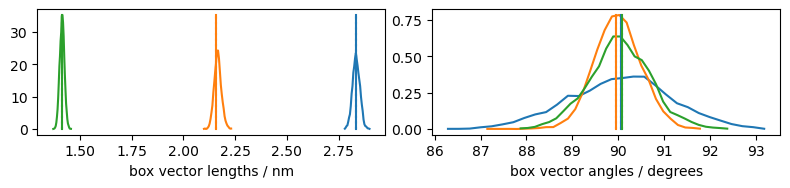

In [122]:
_boxes = load_pickle_('./O/MM/GAFF_sc/mivebresib/data/mivebresib_dataset_I_NPT_cell_121')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/mivebresib/mivebresib_I_equilibrated_cell_121.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

In [ ]:
# Mivebresib Form II

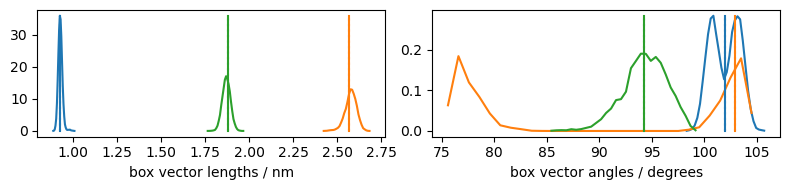

In [123]:
_boxes = load_pickle_('./O/MM/GAFF_sc/mivebresib/data/mivebresib_dataset_II_NPT_cell_221')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/mivebresib/mivebresib_II_equilibrated_cell_221.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

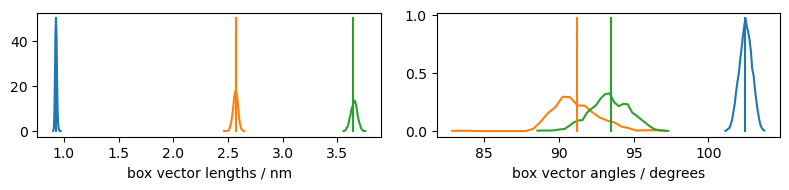

In [124]:
_boxes = load_pickle_('./O/MM/GAFF_sc/mivebresib/data/mivebresib_dataset_II_NPT_cell_222')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/mivebresib/mivebresib_II_equilibrated_cell_222.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

In [ ]:
# Mivebresib Form III

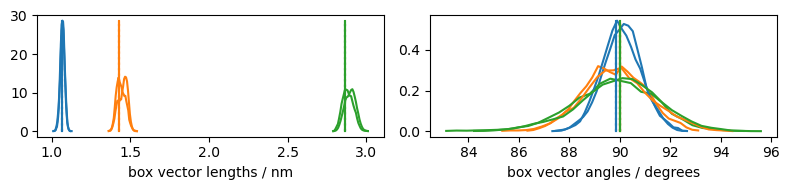

In [127]:
_boxes5ns = load_pickle_('./O/MM/GAFF_sc/mivebresib/data/mivebresib_dataset_III_NPT_cell_111')['MD dataset']['b']
_boxes10ns = load_pickle_('./O/MM/GAFF_sc/mivebresib/data/mivebresib_dataset_III_NPT_cell_111_long')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/mivebresib/mivebresib_IIIs_equilibrated_cell_111.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes5ns, b0=_b1, b1=_b1)
plot_box_lengths_angles_histograms_(_boxes10ns, b0=_b1, b1=_b1)
plt.show()

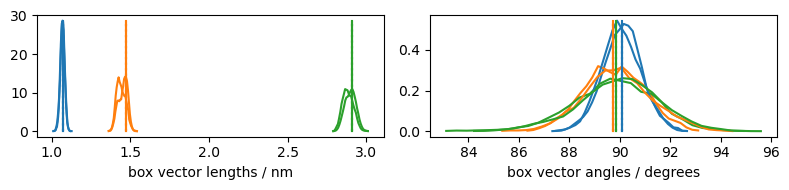

In [128]:
_b1 = PDB_to_box_('./O/MM/GAFF_sc/mivebresib/mivebresib_IIIb_equilibrated_cell_111.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes5ns, b0=_b1, b1=_b1)
plot_box_lengths_angles_histograms_(_boxes10ns, b0=_b1, b1=_b1)
plt.show()

In [131]:
_boxes5ns.shape, _boxes10ns.shape

((50000, 3, 3), (100000, 3, 3))

In [ ]:
#

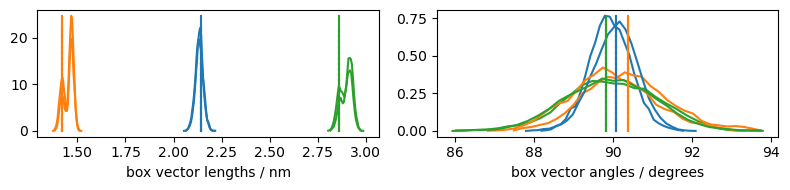

In [132]:
_boxes5ns = load_pickle_('./O/MM/GAFF_sc/mivebresib/data/mivebresib_dataset_III_NPT_cell_211')['MD dataset']['b']
_boxes10ns = load_pickle_('./O/MM/GAFF_sc/mivebresib/data/mivebresib_dataset_III_NPT_cell_211_long')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/mivebresib/mivebresib_IIIs_equilibrated_cell_211.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes5ns, b0=_b1, b1=_b1)
plot_box_lengths_angles_histograms_(_boxes10ns, b0=_b1, b1=_b1)
plt.show()

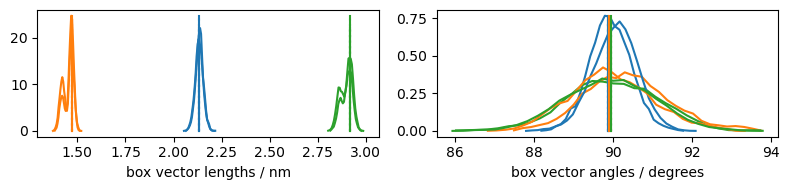

In [134]:
_b1 = PDB_to_box_('./O/MM/GAFF_sc/mivebresib/mivebresib_IIIb_equilibrated_cell_211.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plot_box_lengths_angles_histograms_(_boxes5ns, b0=_b1, b1=_b1)
plot_box_lengths_angles_histograms_(_boxes10ns, b0=_b1, b1=_b1)
plt.show()

In [133]:
_boxes5ns.shape, _boxes10ns.shape

((50000, 3, 3), (100000, 3, 3))

In [ ]:
## ## ## ##

# average from disconnected distribution of angle

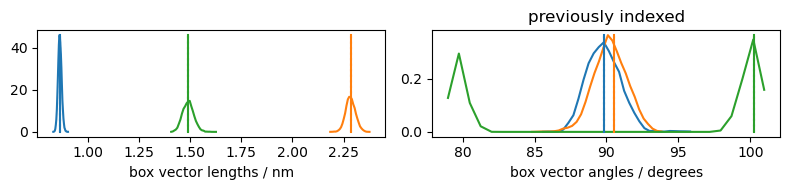

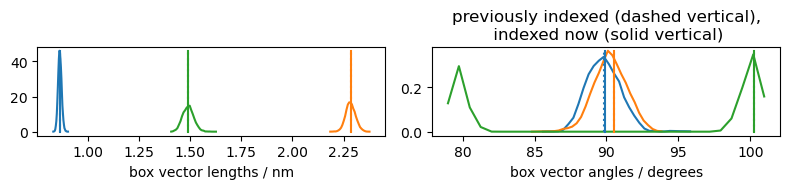

In [201]:
_boxes = load_pickle_('./O/MM/GAFF_sc/veliparib/data/veliparib_dataset_II_NPT_cell_131')['MD dataset']['b']
_b1 = PDB_to_box_('./O/MM/GAFF_sc/veliparib/veliparib_II_equilibrated_cell_131.pdb')
fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plt.title('previously indexed')
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_b1)
plt.show()

lengths_angles = cell_lengths_and_angles_(_boxes)

# index of angle that is oscilating due to wrapping artifact 
problem = 2 # green one

mask = np.zeros([1,6])
mask[0,3+problem] = 1.0
mask_fine = np.array(1.0 - mask)
masked = np.array(mask*lengths_angles)
# just fixing the oscillating angle to the same side (if x is <90, flip to 180-x (> 90)):
average_box = (lengths_angles*mask_fine + np.where(masked<90, 180-masked, masked)*mask).mean(0,keepdims=True)

err = np.abs(average_box - lengths_angles)
err /= err.max(0, keepdims=True)
err = err.sum(-1)
index = np.argmin(err)

fig, ax = plt.subplots(1,2, figsize=(8,2), dpi=100)
plt.title('previously indexed (dashed vertical),\n indexed now (solid vertical)')
plot_box_lengths_angles_histograms_(_boxes, b0=_b1, b1=_boxes[index])
plt.show()

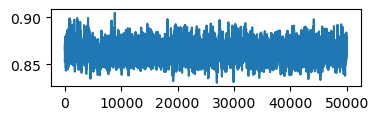

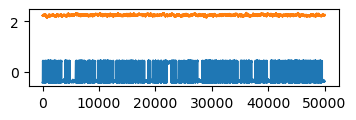

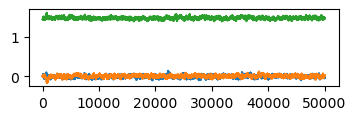

In [203]:
# checking the element of box matrix that was oscilating (b[1,0]; x component of box vector b):
for i in range(3):
    fig = plt.figure(figsize=(4,1))
    for j in range(3):
        if j<=i:
            plt.plot(_boxes[:,i,j])
        else: pass
    plt.show()

In [ ]:
## ## ## ##